# `TODO`

> Additional things to do.

``` HTML
1. Annotate MNE object based on number of targets tracked
2. Annotate MNE object with probe locations
3. Automate wavelength selection based on absorption spectra of hemoglobin
```

---

# Imports

In [1]:
# File r/w
import os

---

In [2]:
# Additional inbuilt utilities
from itertools import chain, compress

In [3]:
# Regex
import re

---

In [4]:
# Array
import numpy as np

In [5]:
# Table
import pandas as pd

In [6]:
import scipy as sc

---

In [7]:
# Plotting
import matplotlib.pyplot as plt

---

In [8]:
# Statistics
import statsmodels.api as sm

---

In [9]:
# fNIRS
import mne

---

In [10]:
# Vistual display
from pyvirtualdisplay import Display

---

In [11]:
# Custom (misc)
import utils

## Config

In [12]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

Using matplotlib as 2D backend.
Using notebook 3d backend.



# Load Data

## fNIRS Data

In [13]:
# Number of hemispheres from which data is collected
N_HEMISPHERES = 1

### NIRX Data (MNE Sample)

In [14]:
# MNE Sample Data
raw = mne.io.read_raw_nirx(mne.datasets.fnirs_motor.data_path() / 'Participant-1', verbose=True)

Loading /home/pulkitgoyal56/mne_data/MNE-fNIRS-motor-data/Participant-1


### ~~RAW.FIF Data~~

In [15]:
# Read '.raw.fif' file
raw_fif = mne.io.read_raw_fif('data/ETH/Front_3Modules/FrontHeadData.raw.fif', preload=True)
raw_fif.crop(tmin=120) # Delete first 60s for this dataset (idle data)

Opening raw data file data/ETH/Front_3Modules/FrontHeadData.raw.fif...
Isotrak not found
    Range : 0 ... 7519 =      0.000 ...   751.900 secs
Ready.
Reading 0 ... 7519  =      0.000 ...   751.900 secs...


<Raw | FrontHeadData.raw.fif, 36 x 6320 (631.9 s), ~1.8 MB, data loaded>

#### Data Specific Constants

In [16]:
# Wavelengths to consider (can choose two -- limitation of MNE, see issue https://github.com/mne-tools/mne-python/issues/9816)
WAVELENGTHS_PICKED = [774, 865]

In [17]:
# Add custom wavelength metadata to MNE Raw Object (as private property)
raw_fif._WAVELENGTHS = WAVELENGTHS_PICKED

---

---

---

### CSV Data

In [18]:
# Read CSV data as Pandas DataFrame
data_pd = pd.read_csv('data/Data_experiment_4_RightLateral_conversion.csv')

In [19]:
data_pd.head(20) # 147540 rows => 147540/12 = 12295 readings

,Time[ms],Channel,BL,855[nm],770[nm],810[nm],885[nm]
0,3481.0,0.0,0.028794,0.495354,1.081621,0.862669,0.731243
1,3481.0,1.0,0.028199,0.804807,1.150561,0.890272,0.661158
2,3481.0,2.0,0.029389,0.633143,0.945846,1.069764,0.818402
3,3481.0,3.0,0.026368,1.442985,0.918929,1.299977,2.390890
4,3481.0,4.0,0.208240,0.645960,0.834836,1.015473,0.580774
5,3481.0,5.0,0.253925,0.674662,0.888899,0.999908,0.567910
6,3481.0,6.0,0.217990,0.581369,0.933532,1.018860,0.446372
7,3481.0,7.0,0.027192,1.276631,1.328176,1.312566,2.062028
8,3481.0,8.0,0.274205,0.662165,0.777981,1.049210,0.627558
9,3481.0,9.0,0.221103,0.763424,0.772763,1.043671,0.569604


#### Data Specific Constants

In [20]:
# Wavelengths to consider (can choose two -- limitation of MNE, see issue https://github.com/mne-tools/mne-python/issues/9816)
WAVELENGTHS_PICKED = [855, 770]

In [21]:
# Unused Channels
CH_UNUSED = {3, 7, 11}

In [22]:
# Source-Detector pairs (all)
S_D = ['S44_D44', 'S39_D39', 'S43_D43', 'S44_D44', 'S44_D39', 'S44_D43', 'S39_D44', 'S39_D39', 'S39_D43', 'S43_D44', 'S43_D39', 'S43_D43'] # Decimal
# ['S2C_D2C', 'S27_D27', 'S2B_D2B', 'S2C_D2C', 'S2C_D27', 'S2C_D2B', 'S27_D2C', 'S27_D27', 'S27_D2B', 'S2B_D2C', 'S2B_D27', 'S2B_D2B'] # Hexadecimal

---

In [23]:
# Wavelengths availables (automatic extraction)
WAVELENGTHS = [int(match.groups()[0]) for column in data_pd.columns if (match := re.compile(r'(\d+)\[nm\]').match(column))] # [855, 770, 810, 885]

In [24]:
# Total number of wavelengths
N_WAVELENGTHS_T = len(WAVELENGTHS)

In [25]:
# Number of wavelengths used in analysis
N_WAVELENGTHS = len(WAVELENGTHS_PICKED) # 2

In [26]:
# Number of probes
N_PROBES = 3 # Per Hemisphere

In [27]:
# Number of expected channels
N_CHANNELS = N_PROBES**2  # *N_WAVELENGTHS_T Per Hemisphere

---

In [28]:
# Dictionary (map) of channel number to channel name
CH_MAP = dict(zip(map(int, data_pd['Channel'].unique()), S_D))
print(CH_MAP)

{0: 'S44_D44', 1: 'S39_D39', 2: 'S43_D43', 3: 'S44_D44', 4: 'S44_D39', 5: 'S44_D43', 6: 'S39_D44', 7: 'S39_D39', 8: 'S39_D43', 9: 'S43_D44', 10: 'S43_D39', 11: 'S43_D43'}


In [29]:
# Short Channels
CH_SHORT = set(utils.find_short_channels(S_D)[1]) - CH_UNUSED

In [30]:
# Long Channels
CH_LONG = set(utils.find_long_channels(S_D)[1]) - CH_UNUSED

In [31]:
# Used Channels
CH_USED = CH_SHORT.union(CH_LONG)

---

In [32]:
# Names of the wavelength specific channels (only used channels)
CH_NAMES = [f'{CH_MAP[ch]} {wavelength}'
            for ch in list(CH_MAP.keys()) if ch not in CH_UNUSED # product(range(N_PROBES), repeat=2)
            for wavelength in WAVELENGTHS]
print(CH_NAMES) # (12 total - 3 unused) * 4 wavelengths = 36

['S44_D44 855', 'S44_D44 770', 'S44_D44 810', 'S44_D44 885', 'S39_D39 855', 'S39_D39 770', 'S39_D39 810', 'S39_D39 885', 'S43_D43 855', 'S43_D43 770', 'S43_D43 810', 'S43_D43 885', 'S44_D39 855', 'S44_D39 770', 'S44_D39 810', 'S44_D39 885', 'S44_D43 855', 'S44_D43 770', 'S44_D43 810', 'S44_D43 885', 'S39_D44 855', 'S39_D44 770', 'S39_D44 810', 'S39_D44 885', 'S39_D43 855', 'S39_D43 770', 'S39_D43 810', 'S39_D43 885', 'S43_D44 855', 'S43_D44 770', 'S43_D44 810', 'S43_D44 885', 'S43_D39 855', 'S43_D39 770', 'S43_D39 810', 'S43_D39 885']


In [33]:
# Type of channels -- Raw fNIRS Continuous Wave Amplitude
# https://mne.tools/stable/glossary.html#term-data-channels
CH_TYPES = 'fnirs_cw_amplitude' # [] * N_CHANNELS * N_WAVELENGTHS_T * N_HEMISPHERES

In [34]:
# Sampling frequency (based on difference between timestamps in consecutive readings ~54ms)
F_S = 1000/np.ptp(data_pd['Time[ms]'])*(len(data_pd) - len(S_D))/len(S_D) # 1000/54.319 ~ 18.41 Hz

---

In [35]:
# Remove unused channels and create a new DataFrame
data_pd_ = data_pd.loc[data_pd['Channel'].isin(CH_USED)]

In [36]:
# Check if the number of channels are as expected (they must not be more than `N_CHANNELS`)
if len(data_pd_['Channel'].unique()) != N_CHANNELS:
    print(f'Unexpected number of channels. Expected - {N_CHANNELS}; Received - {len(data_pd_["Channel"].unique())}')

In [37]:
# Timestamps (for used channels only)
tms = data_pd_['Time[ms]']

# Backlight intesities (for used channels only)
bkl = data_pd_['BL']

#### Backlight Removal

In [38]:
# Fit 3rd-order polynomial to backlight data
rlm_results = sm.RLM(bkl, np.c_[np.ones_like(bkl), # Constant
                                (t1 := np.arange(len(data_pd))[data_pd['Channel'].isin(CH_USED)]), t1**2, t1**3, # Timestamp (^1, ^2, ^3) with consideration to time spent recording unused channels
                                # (t2 := np.arange(len(bkl))), t2**2, t2**3 # Timestamp (^1, ^2, ^3) without consideration to time spent recording unused channels
                               ]).fit()

In [39]:
# Subtract predicted backlight signal from raw data of all wavelengths and remove other columns ('Time[ms]', 'BL', and 'Channel')
data_pd_ = data_pd_[data_pd.columns[-N_WAVELENGTHS_T:]] - np.tile(rlm_results.fittedvalues, (N_WAVELENGTHS_T, 1)).T

In [40]:
# DataFrame with backlight-removed signal intensities (the rows are chunked in groups of `N_CHANNELS` (number of used channels),
# i.e. first 9 rows = recoding 1; second 9 rows = recording 2; ...)
data_pd_.head(10)

,855[nm],770[nm],810[nm],885[nm]
0,0.495354,1.081621,0.862669,0.731243
1,0.804794,1.150548,0.890260,0.661146
2,0.633118,0.945821,1.069739,0.818377
4,0.645910,0.834787,1.015423,0.580724
5,0.674600,0.888837,0.999846,0.567848
6,0.581294,0.933457,1.018785,0.446297
8,0.662066,0.777882,1.049111,0.627458
9,0.763312,0.772651,1.043559,0.569492
10,0.681267,0.754419,1.043501,0.555746
12,0.495204,1.080922,0.863618,0.731643


#### MNE Object

In [41]:
# Create Numpy Array from the corrected DataFrame and reshape it to have rows corresponding to time-Warying signal for all channel and picked wavelength combinations
# 36 rows; each corresponding in order to `CH_NAMES`
data_np_ = np.array(data_pd_).reshape(-1, N_CHANNELS * N_WAVELENGTHS_T).T

In [42]:
# Create MNE.Info Object
info_csv = mne.create_info(ch_names=CH_NAMES, sfreq=F_S, ch_types=CH_TYPES)

---

`Manually update info object parameters for location`
> Manual modification is not recommended, but there doesn't seem to any other option as there are no inbuilt functions for this.  
> https://github.com/mne-tools/mne-python/blob/main/mne/io/meas_info.py#L2425  
>> __Info__: `mne.info['chs'][x]['loc']` is an array of channel 'location' of length 12.  
>> From investigation, it is apparent that,  
>>> - [0:3] is the midpoint (channel) location (= <source_location + detector_location>/2)  
>>> - [3:6] is the source location  
>>> - [6:9] is the detector location  
>>> - [9] is the frequency  
>>> - [10] seems to be always `nan`; function unknown  
>>> - [11] is a specific number that corresponds to the separation of the channel, i.e. short (0.007) or long (0.03); function unknown  

In [43]:
for chs in info_csv['chs']:
    # For fNIRS, the 10th element corresponds to the wavelength
    # https://github.com/mne-tools/mne-python/blob/main/mne/preprocessing/nirs/nirs.py#L150
    chs['loc'][9] = float(chs['ch_name'].split()[1])

In [44]:
for chs in info_csv['chs']:
    # For fNIRS, the 12th element is some number that depends on whether the channel is short (0.007) or long (0.03)
    # TODO: find significance of this number
    # > No specific reference to this 11th index found in the MNE-Python source code
    # >> Only references to range of values ('[:]' or '[3:]') in device-spcific functions with no apparent applicability to the context here
    chs['loc'][11] = 0.007 if utils.is_short_channel(chs['ch_name']) else 0.03

In [45]:
# Copy other meta data from sample *fif* file
info_csv['device_info'] = raw_fif.info['device_info'] # {'type': 'fNIRS-CW', 'model': 'optoHIVE'}
info_csv['experimenter'] = raw_fif.info['experimenter'] # 'optoHIVE Team'
# meas_date # datetime.datetime(2022, 12, 16, 14, 36, 20, 620708, tzinfo=datetime.timezone.utc)
# file_id (== meas_id)
# meas_id (== file_id)

---

In [46]:
# Create MNE.IO.Raw Object
raw_csv = mne.io.RawArray(data_np_, info_csv)

Creating RawArray with float64 data, n_channels=36, n_times=12295
    Range : 0 ... 12294 =      0.000 ...   667.803 secs
Ready.


In [47]:
# Add custom wavelength metadata to MNE Raw Object (as private property)
raw_csv._WAVELENGTHS = WAVELENGTHS_PICKED

## Experiment Data

`Stages of the experiment`
> *\<exp\>* → **\[ *\<tri\>* = *\<wait1\>* → *\<target\>* → *\<motion\>* → *\<probe\>* → *\<feedb\>* → *\<feedbEnd\>* \]** → *\<expEnd\>*

In [48]:
# Load Experiment Results
mat = pd.DataFrame(sc.io.loadmat('data/s1b4.mat')['blockdata'], columns=[
    'experiment_number',     # 0     # <trl.exp_number>              # experiment number
    'subject_number',        # 1     # <trl.sub_number>              # subject number
    'trial_number',          # 2     # <trl.num>                     # trial number

    'num_targets',           # 3     # <trl.numTargets(trl.num)>     # number of targets ({0, 2, 3, 4, 5})
    'probe_match',           # 4     # <trl.probeMatch(trl.num)>     # target (1) or not (0)

    'checker_pres',          # 5     # <trl.checkerPres(trl.num)>    # 0 -- ??
    'checker_side',          # 6     # <trl.checkerSide(trl.num)>    # 0 -- ??

    'id_correct',            # 7     # <dat.IDcor>                   # correct (1), incorrect (2), other (3), none (4)

    'rt_correct',            # 8     # <dat.RTcor>                   # {∈ (trl.RTmin, trl.RTmax)} (1), {≤ trl.RTmin (2)}, {≥ trl.RTmax} (3), {> trl.RTmaxWait} (4)

    'rt',                    # 9     # <dat.RT>                      # reaction time, in seconds

    'tri_e',                 # 10    # <time.triE>                   # <tri - exp> -- trial starting time, relative to start of the experiment, in seconds
    'wait_e',                # 11    # <time.waitE>                  # <wait1 - exp> -- ??
    'target_e',              # 12    # <time.targetE>                # <target - exp> -- target display time, relative to start of the experiment, in seconds
    'motion_e',              # 13    # <time.motionE>                # <motion - exp> -- motion start time, relative to start of the experiment, in seconds
    'probe_e',               # 14    # <time.probeE>                 # <probe - exp> -- response collection time, relative to start of the experiment, in seconds

    'tri_t',                 # 15    # <time.triT>                   # <tri - tri> -- trial starting time, relative to start of the trial, in seconds
    'wait_t',                # 16    # <time.waitT>                  # <wait - tri> -- ??
    'target_t',              # 17    # <time.targetT>                # <target - tri> -- target display time, relative to start of the trial, in seconds
    'motion_t',              # 18    # <time.motionT>                # <motion - tri> -- motion start time, relative to start of the trial, in seconds
    'probe_t',               # 19    # <time.probeT>                 # <probe - tri> -- response collection time, relative to start of the trial, in seconds

    'wait_p',                # 20    # <time.waitP>                  # <target - wait1> -- wait duration, in seconds
    'target_p',              # 21    # <time.targetP>                # <motion - target> -- target presentation duration, in seconds
    'motion_p',              # 22    # <time.motionP>                # <probe - motion> -- motion duration, in seconds
    'probe_p',               # 23    # <time.probeP>                 # <feedb - probe> -- time window for response input, in seconds
    'feedb_p'                # 24    # <time.feedbP>                 # <feedbEnd - feedb> -- response feedback report duration, in seconds
])

In [49]:
mat.loc[:5, mat.columns[9:]]

,rt,tri_e,wait_e,target_e,motion_e,probe_e,tri_t,wait_t,target_t,motion_t,probe_t,wait_p,target_p,motion_p,probe_p,feedb_p
0,1.178703,0.163018,0.180914,6.148375,8.134235,18.134181,0.000087,4.991613,5.985356,7.971216,17.971162,5.967461,1.985860,9.999946,1.993683,1.974282
1,0.983480,22.109235,22.134774,28.096173,30.084363,40.084203,0.000154,4.993334,5.986938,7.975128,17.974967,5.961399,1.988190,9.999840,1.994032,1.973392
2,1.800306,44.056405,44.080523,50.041681,52.034193,62.034307,0.000121,4.991844,5.985276,7.977789,17.977903,5.961157,1.992513,10.000114,1.993719,1.973668
3,1.201405,66.006537,66.027437,71.988553,73.984323,83.984201,0.000092,4.988615,5.982016,7.977785,17.977664,5.961116,1.995770,9.999878,1.993750,1.973488
4,0.892915,87.956879,87.981263,93.942592,95.934395,105.934476,0.000382,4.992202,5.985713,7.977516,17.977597,5.961329,1.991803,10.000081,1.993765,1.973575
5,1.264706,109.914409,109.941691,115.903100,117.900842,127.900993,0.000030,4.995248,5.988691,7.986433,17.986585,5.961409,1.997742,10.000152,1.993738,1.973485


#### Data Specific Constants

In [50]:
# Create dictionary of all the durations of a trial by looking for all the columns with names ending with '_p'
DUR = mat.filter(regex=(".*_p$")).mean().round().rename(lambda c_n: c_n[:-2]) # .astype(int)
DUR['trial'] = sum(DUR)

# Read experiment end time, relative to its start time, vis-à-vis its duration
DUR['exp'] = float(sc.io.loadmat('data/s1b4EndTime.mat')['expEnd'])  # <expEnd - exp> -- duration of the entire experiment, in seconds

# (time in seconds)
print(DUR)

wait        6.000000
target      2.000000
motion     10.000000
probe       2.000000
feedb       2.000000
trial      22.000000
exp       664.706839
dtype: float64


In [51]:
# Read experiment end time and set start time
T_EXP_START = -0.1                   # <exp>                         # experiment start time, in seconds; offset due to trigger delay
T_EXP_END = T_EXP_START + DUR['exp']                                 # experiment end time, in seconds

# Set recording start and end times
T_REC_START = 0                                                      # fNIRS recording start time, in seconds
T_REC_END = data_pd['Time[ms]'].iloc[-1]/1000                        # fNIRS recording end time, in seconds # np.ptp(data_pd['Time[ms]'])

---

In [52]:
# QUES - Why is `data_pd['Time[ms]'][0]` not 0?!
print(f'''{data_pd['Time[ms]'][0]/1000 = }s''')

data_pd['Time[ms]'][0]/1000 = 3.481s


In [53]:
# QUES - Why is `T_REC_END` != `T_EXP_END`?!
print(f'{T_REC_END = :.3f}s')
print(f'{T_EXP_END = :.3f}s')

T_REC_END = 671.284s
T_EXP_END = 664.607s


# Prepare Data

In [54]:
# Set non-interactive plotting backend for Matplotlib
%matplotlib inline

In [55]:
# Set a MNE object variable that is used for all subsequent analysis
# This is done so that different data can be analysed simply by reassigning this variable and re-running the cells below

# raw_intensity = raw.copy()
raw_intensity = raw_csv.copy()
# raw_intensity = raw_fif.copy()

### Pick Long Channels and Filter Wavelengths

In [56]:
# Pick long channels (for every wavelength)
raw_intensity.pick([ch for ch in utils.find_long_channels(raw_intensity.ch_names)[0] if int(ch.split()[1]) in raw_intensity._WAVELENGTHS])

<RawArray | 12 x 12295 (667.8 s), ~1.1 MB, data loaded>

### Montages (Locations)

In [57]:
# LOC = {
#     '44': (44.8, -87.9, 59.6), # P4     # PIPS     # 2C
#     '39': (64.2, -15.2, 69.9), # C4     # AIPS     # 27
#     '43': (54.5, -51.5, 64.7)  # C4|P4  # IPS      # 2B
# }

In [58]:
# np.sqrt(np.sum((np.array([44.8, -87.9, 59.6]) - np.array([64.2, -15.2, 69.9]))**2)) # 75.94563845277753

In [59]:
montage = mne.channels.read_custom_montage('data/custom_optode.elc', coord_frame='mri')
raw_intensity.set_montage(montage)

/tmp/ipykernel_296371/2455740974.py:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_intensity.set_montage(montage)


<RawArray | 12 x 12295 (667.8 s), ~1.1 MB, data loaded>

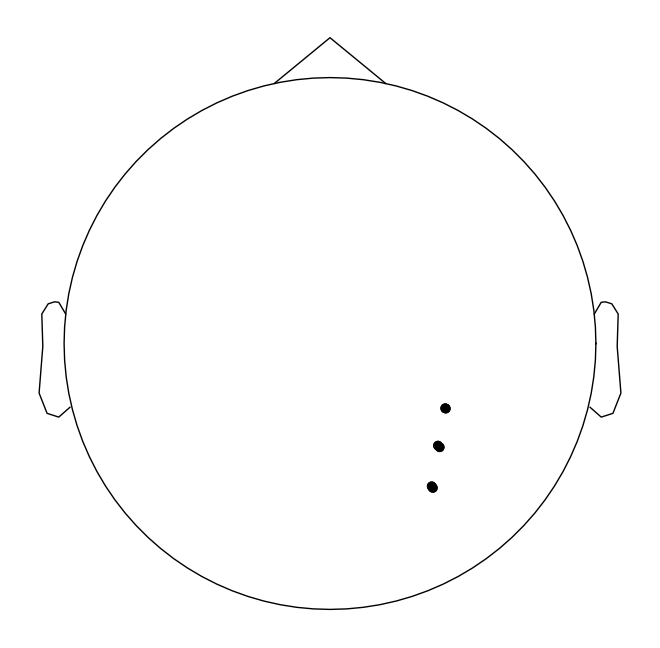

In [60]:
# View the position of optodes in 2D to confirm the positions are correct.
raw_intensity.plot_sensors();

### Annotations

`Stages of the experiment`
> *\<exp\>* → **\[ *\<tri\>* = *\<wait1\>* → *\<target\>* → *\<motion\>* → *\<probe\>* → *\<feedb\>* → *\<feedbEnd\>* \]** → *\<expEnd\>*

### Initial Plots

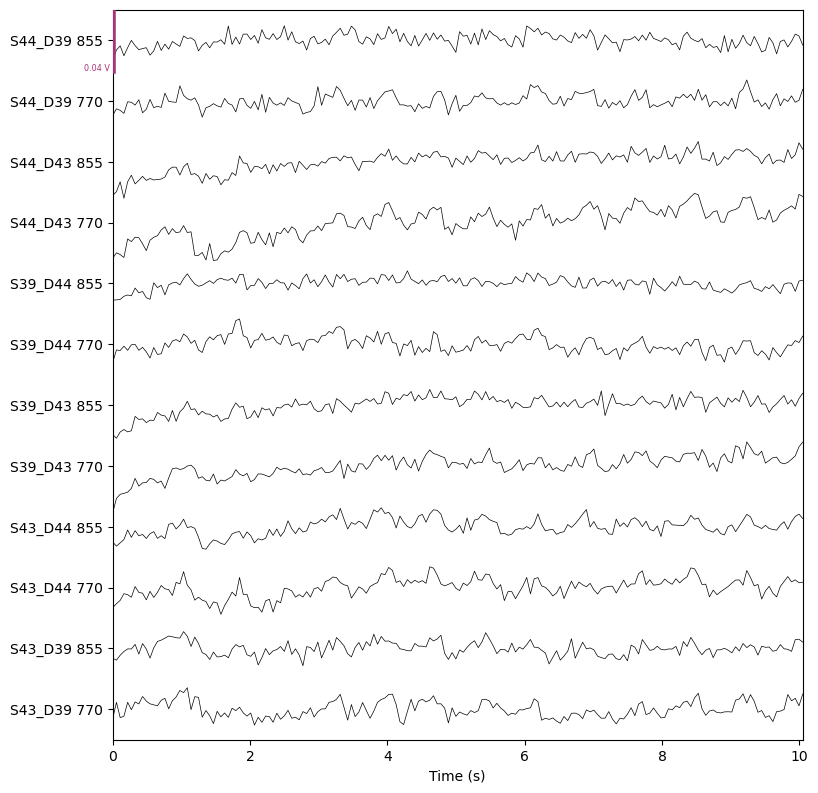

In [61]:
# Plot raw signals (CW amplitude)
raw_intensity.plot(show_scrollbars=False);

Effective window size : 13.906 (s)


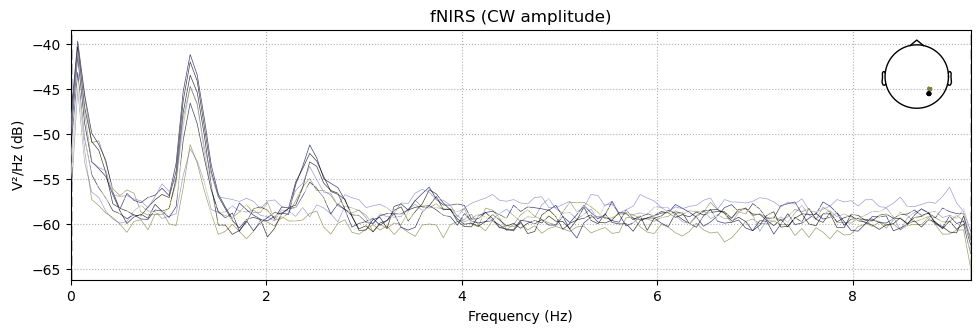

In [62]:
raw_intensity.compute_psd().plot();

# Pre-Processing

In [63]:
# Set non-interactive backend for Matplotlib
%matplotlib inline

### Remove Instrument Drift and Noise

### Raw -> Optical Densities

> https://github.com/mne-tools/mne-python/blob/main/mne/preprocessing/nirs/_optical_density.py

In [64]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

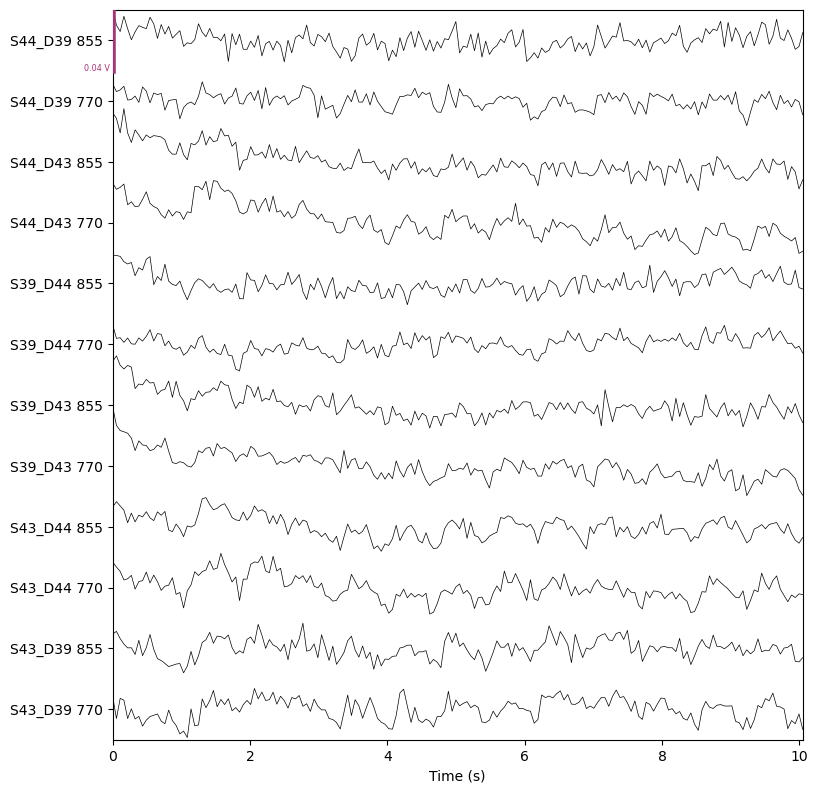

In [65]:
# Plot optical density signals
raw_od.plot(show_scrollbars=False);

### Motion Artifact Removal

> TDDR

In [66]:
corrected_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od)

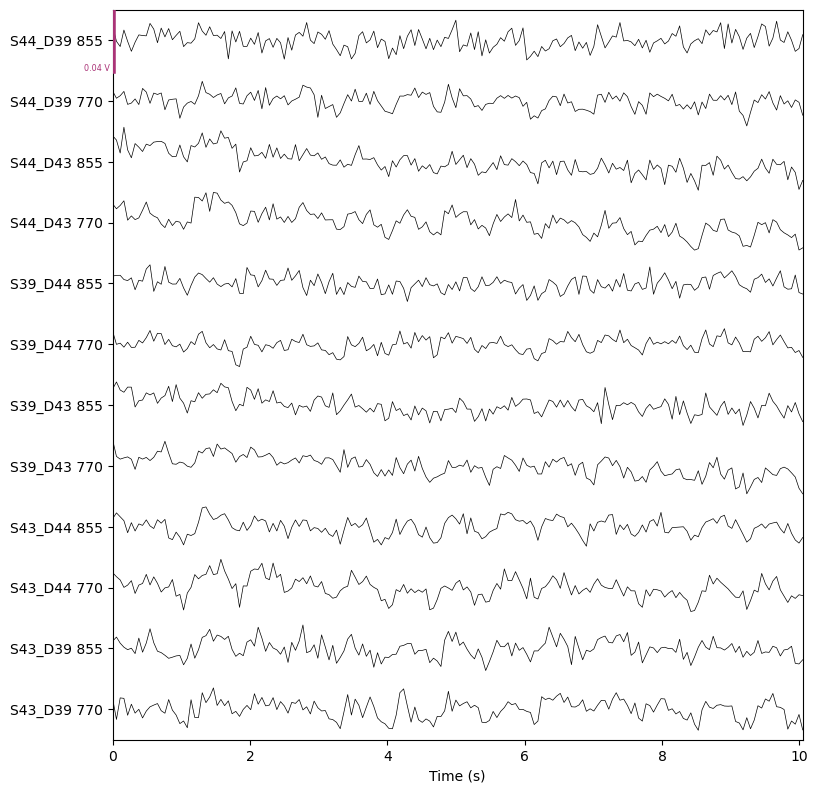

In [67]:
# Plot corrected optical density signals
corrected_od.plot(show_scrollbars=False);

`Compute Scalp Coupling Index for Quality Check`

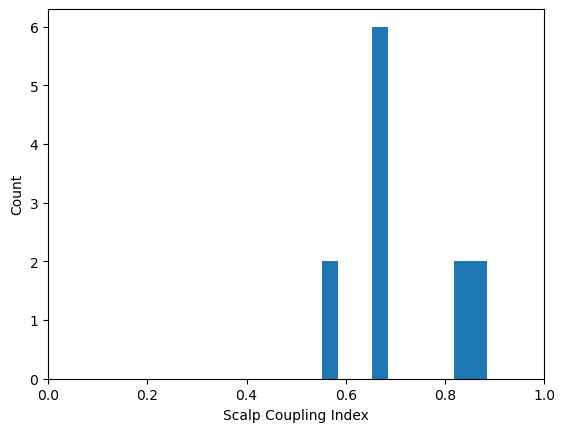

In [68]:
# Channels with SCI < 0.5 are 'bad'
sci = mne.preprocessing.nirs.scalp_coupling_index(corrected_od)
plt.hist(sci)
plt.xlabel('Scalp Coupling Index')
plt.ylabel('Count')
plt.xlim([0, 1])
plt.show()

In [69]:
# Mark (in)appropriate channels as 'bad'
corrected_od.info['bads'] = list(compress(corrected_od.ch_names, sci < 0.5))

### Optical Densities -> HbO and HbR concentrations

> MBBL  
>> Differential path length factor  
>> - 6.1 at 760 nm  
>> - 5.6 at 850 nm

In [70]:
# Use Modified Beer Lambert Law to calculated the chromophore concentrations
# `ppf` -- the partial pathlength factor
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_od, ppf=0.1) # 6.0

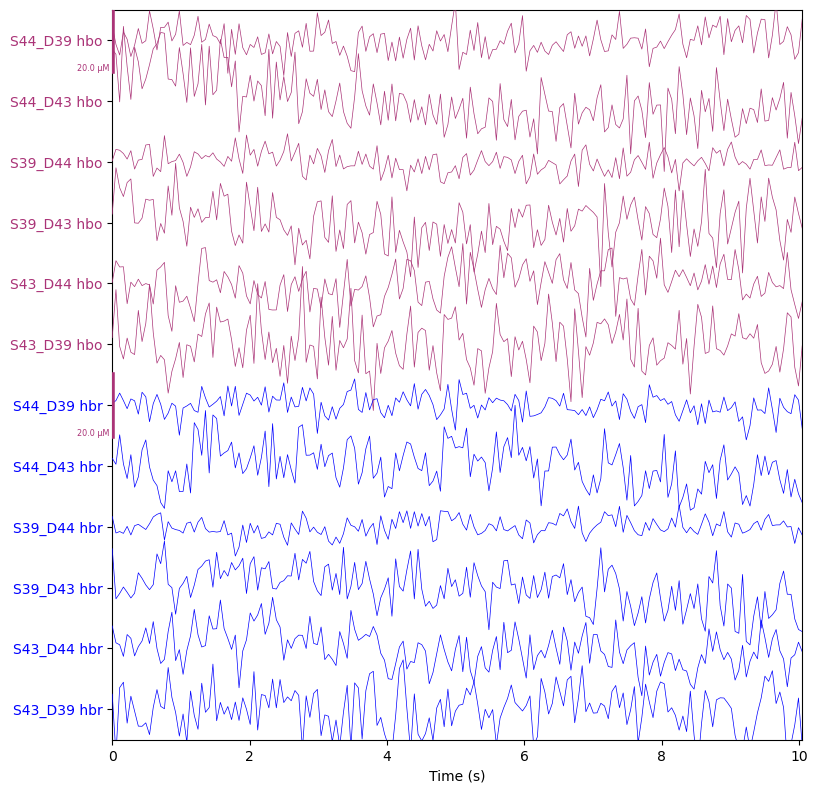

In [71]:
# Plot chromophore (HbO and HbR) signals
raw_haemo.plot(show_scrollbars=False);

### Filtering

> Remove heart-beat signal  
>> = HR Band ~(0.01 Hz - 0.3 Hz) +  
>> = MW Band ~(0.07 Hz - 0.14 Hz)

Effective window size : 13.906 (s)


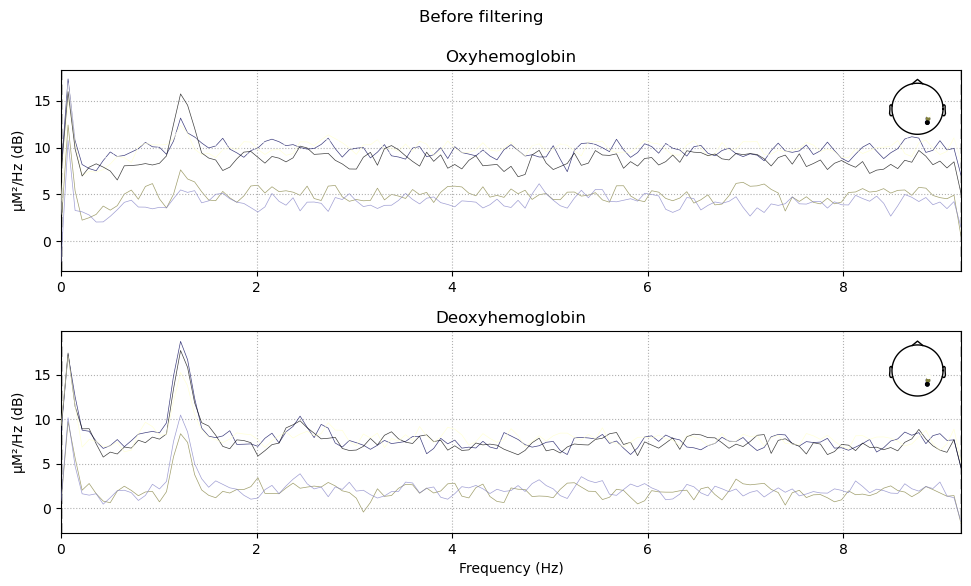

In [72]:
# View power spectral densities of the Hb signals
fig = raw_haemo.compute_psd().plot(average=False)
fig.suptitle('Before filtering')
fig.subplots_adjust(top=0.88)

In [73]:
# The haemodynamic response has frequency content predominantly below 0.5 Hz.
# An increase in activity around 1 Hz can be seen in the data that is due to the person’s heart beat and is unwanted.
# So we use a low pass filter to remove this.
# A high pass filter is also included to remove slow drifts in the data.
raw_haemo = raw_haemo.filter(0.02, 0.4, h_trans_bandwidth=0.2, l_trans_bandwidth=0.01)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.40 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6077 samples (330.099 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished


Effective window size : 13.906 (s)


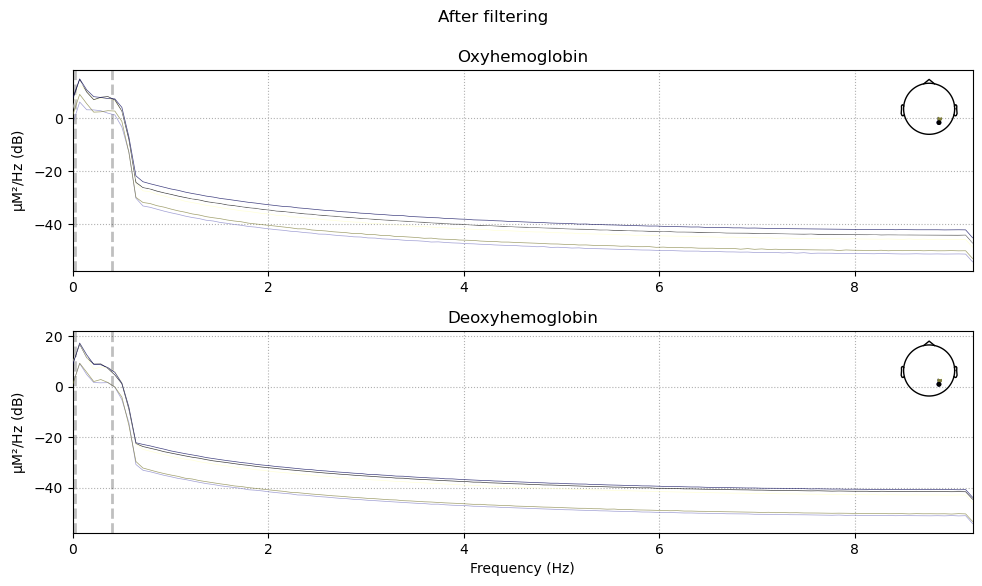

In [74]:
# View power spectral densities of the filtered Hb signals
fig = raw_haemo.compute_psd().plot(average=False)
fig.suptitle('After filtering')
fig.subplots_adjust(top=0.88)

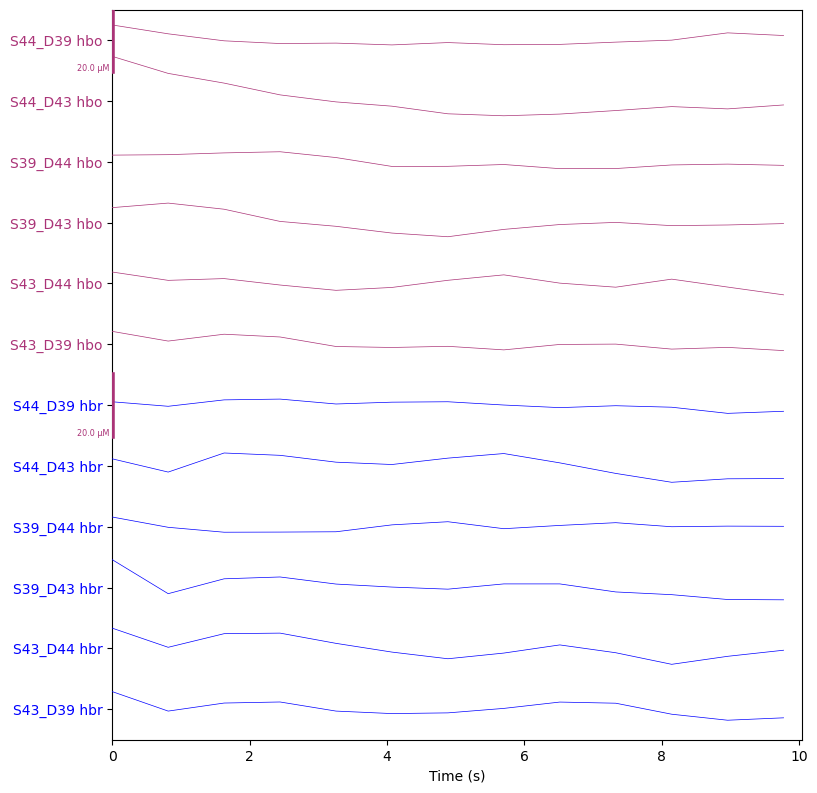

In [75]:
# Plot filtered chromophore (HbO and HbR) signals
raw_haemo.plot(show_scrollbars=False);

### Channel Selection

> Automatic -- Heart Rate Based  
> Automatic -- RMS Threshold Based

# MAIN

In [76]:
# Set non-interactive plotting backend for Matplotlib
%matplotlib inline

## GLM

> Short-Channel Regression

## Statistics

# ---

